In [64]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from IPython.display import Image

from fastai.vision import *
from fastai import *
from fastai.widgets import *

In [4]:
! mkdir data
! mkdir data/images
# download url_csv folder into data folder

mkdir: data: File exists
mkdir: data/images: File exists


In [5]:
### hyperparameters ### 
batch_size = 32
max_pics = 10000
transforms = get_transforms()
path = Path('.')
path_images = Path('data/images')
path_urls = Path('data/url_csv')
np.random.seed(42)

# Data downloading

In [18]:
# get list of filenames as csv
! ls {path_urls} > "data/filenames.csv"

In [56]:
# download and verify images from list of csv files each containing iamge urls

def download_and_verify_images(fnames):
    for fname in fnames:
        dest = path_images/fname[:-4] 
        urls = path_urls/fname
        dest.mkdir(exist_ok=True)
        if len(dest.ls()) == 0:
            print("***"*5,f"Downloading {fname} images","***"*5)
            download_images(urls,dest,max_pics=max_pics)
            verify_images(dest,delete=True)
        else: 
            print("***"*5,f"{fname[:-4]} images exist","***"*5)
    print("\n"+"***"*21)
    print("***"*5,"Finished downloading all images","***"*5)
    print("***"*21)

In [57]:
fnames = np.genfromtxt(path/'data/filenames.csv',dtype='str')
download_and_verify_images(fnames)

*************** chiffon images exist ***************
*************** denim images exist ***************
*************** faux_fur images exist ***************
*************** faux_leather images exist ***************
*************** lace images exist ***************
*************** linen images exist ***************
*************** satin images exist ***************
*************** sequin images exist ***************
*************** velvet images exist ***************

***************************************************************
*************** Finished downloading all images ***************
***************************************************************


# Data loading & Preprocessing
- train, val split
- create batches
- preprocessing: augmentation, resize, normalization

In [59]:
data = ImageDataBunch.from_folder(path_images,         # path for the dataset and model 
                                  valid_pct=0.2,       # train / val split
                                  ds_tfms=transforms,  # transforms
                                  size=224,            # image size
                                  bs=batch_size)       # batch size
data.normalize(imagenet_stats)                         # normalization

ImageDataBunch;

Train: LabelList (3824 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
velvet,velvet,velvet,velvet,velvet
Path: data/images;

Valid: LabelList (956 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
satin,denim,denim,lace,faux_leather
Path: data/images;

Test: None

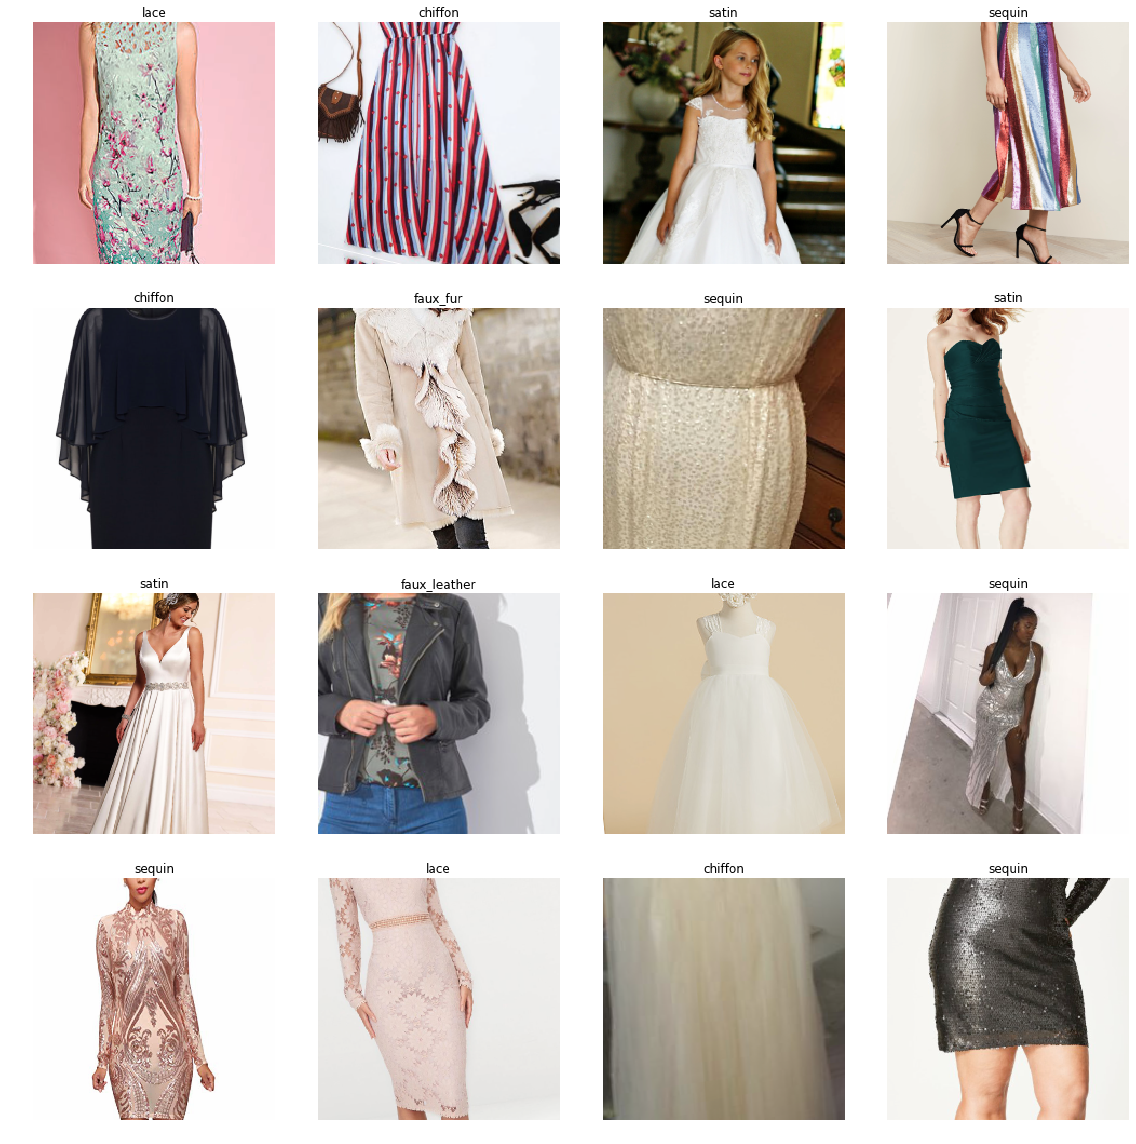

In [21]:
data.show_batch(rows=4)

In [18]:
print(data.c, data.classes)

9 ['chiffon', 'denim', 'faux_fur', 'faux_leather', 'lace', 'linen', 'satin', 'sequin', 'velvet']


### check class balance

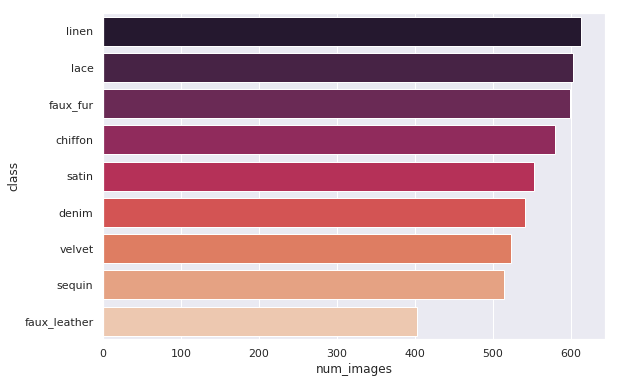

In [22]:
# count the number of images in each class folder
num_images = [len(Path(path_images/class_).ls()) for class_ in data.classes]
classes = pd.DataFrame({'class':data.classes, 
                                 'num_images':num_images}).sort_values('num_images', ascending=False)
sns.set(rc={'figure.figsize':(9,6)})
sns.barplot('num_images','class', data=classes, palette='rocket')

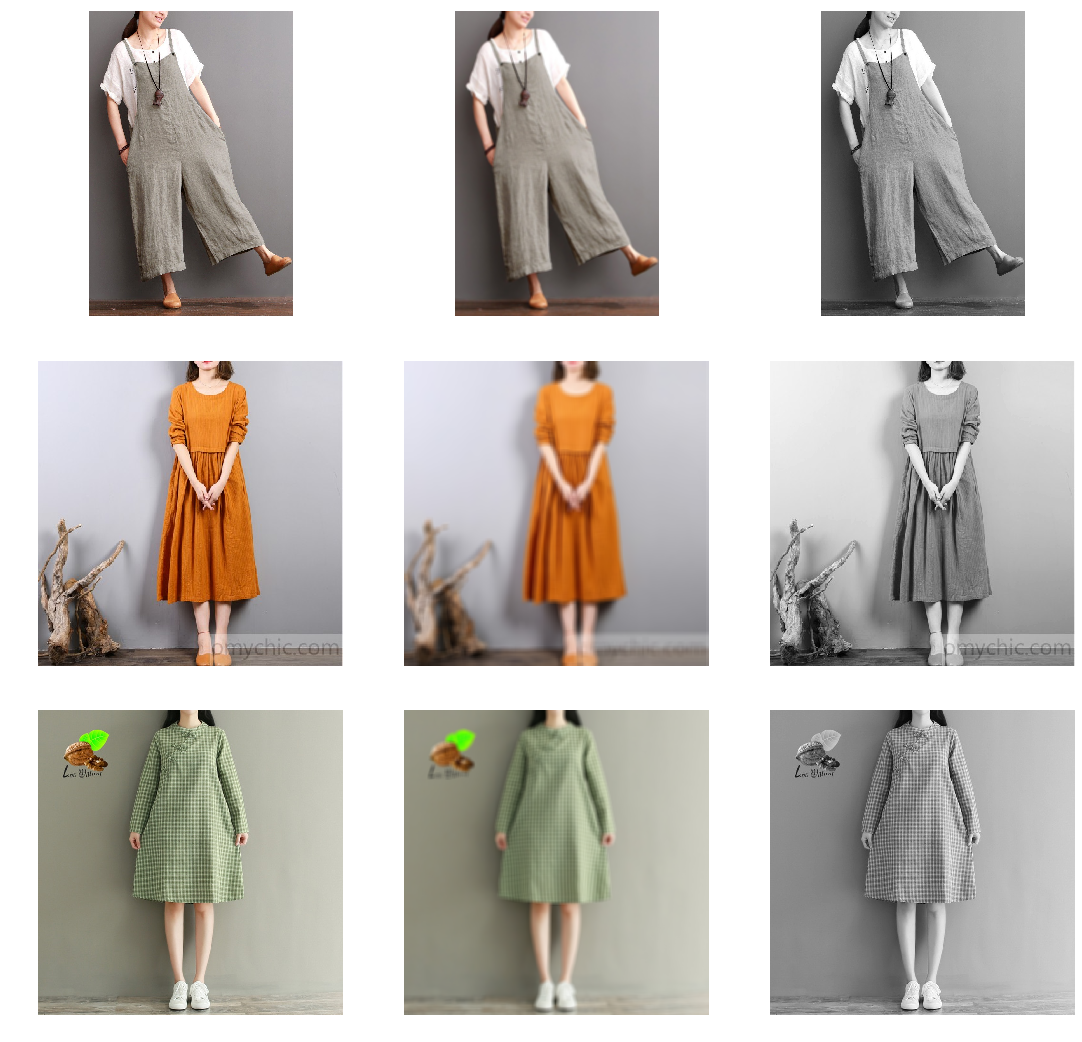

In [38]:
# plot blurred and grayscale version alongside original image
def plot_blur_gray(images):
    n = len(images)
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(16,4*n))
    ax = axes.ravel()
    for i,image in enumerate(images):
        img = cv.imread(image)
        blur = cv.blur(img,(10,10))
        blur = cv.cvtColor(blur, cv.COLOR_BGR2RGB)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        ax[3*i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        ax[3*i].axis('off')
        ax[3*i+1].imshow(blur)
        ax[3*i+1].axis('off')
        ax[3*i+2].imshow(gray, cmap='gray')
        ax[3*i+2].axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=1.2)
    plt.show()

images = [f'data/images/linen/0000000{i}.jpg' for i in range(5,8)]
plot_blur_gray(images)

In [65]:
# create seperate folders for all gray and blur images
path_images_blur = Path('data/images_blurred')
path_images_blur.mkdir(exist_ok=True)
path_images_gray = Path('data/images_grayscale')
path_images_gray.mkdir(exist_ok=True)

In [66]:
# transform each image and save to corresponding folder
for c in data.classes:
    folder = path_images/c
    gray_folder = path_images_gray/c              
    gray_folder.mkdir(exist_ok=True)
    blur_folder = path_images_blur/c
    blur_folder.mkdir(exist_ok=True)
    
    print('***'*5, f'Transforming images in {c}', '***'*5)
    for i,file_path in enumerate(folder.ls()):
        file_path = str(file_path)  
        imageID = file_path.split('.')[0][-8:]                # get the image file ID eg. 00000001
        gray_path = str(gray_folder/imageID)+'_gray.jpg'      # add suffix to image file name 
        blur_path = str(blur_folder/imageID)+'_blur.jpg'
        img = cv.imread(file_path)                             # read image
        if img is not None:
            gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)     # transform image
            blur_img = cv.blur(img,(10,10))                    # transform image
            cv.imwrite(gray_path,gray_img)                     # save image to corresponding folder
            cv.imwrite(blur_path,blur_img) 
    
print('***'*5, 'Finished transforming all images', '***'*5)

*************** Transforming images in chiffon ***************
*************** Transforming images in denim ***************
*************** Transforming images in faux_fur ***************
*************** Transforming images in faux_leather ***************
*************** Transforming images in lace ***************
*************** Transforming images in linen ***************
*************** Transforming images in satin ***************
*************** Transforming images in sequin ***************
*************** Transforming images in velvet ***************
*************** Finished transforming all images ***************


In [67]:
# load blurred and grayscale images into databunch
data_blur = ImageDataBunch.from_folder(path_images_blur,    # path for the dataset and model 
                                       valid_pct=0.2,       # train / val split
                                       ds_tfms=transforms,  # transforms
                                       size=224,            # image size
                                       bs=batch_size)       # batch size
data_blur.normalize(imagenet_stats)                         # normalization

ImageDataBunch;

Train: LabelList (3856 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
velvet,velvet,velvet,velvet,velvet
Path: data/images_blurred;

Valid: LabelList (964 items)
x: ImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
faux_leather,linen,linen,lace,faux_fur
Path: data/images_blurred;

Test: None

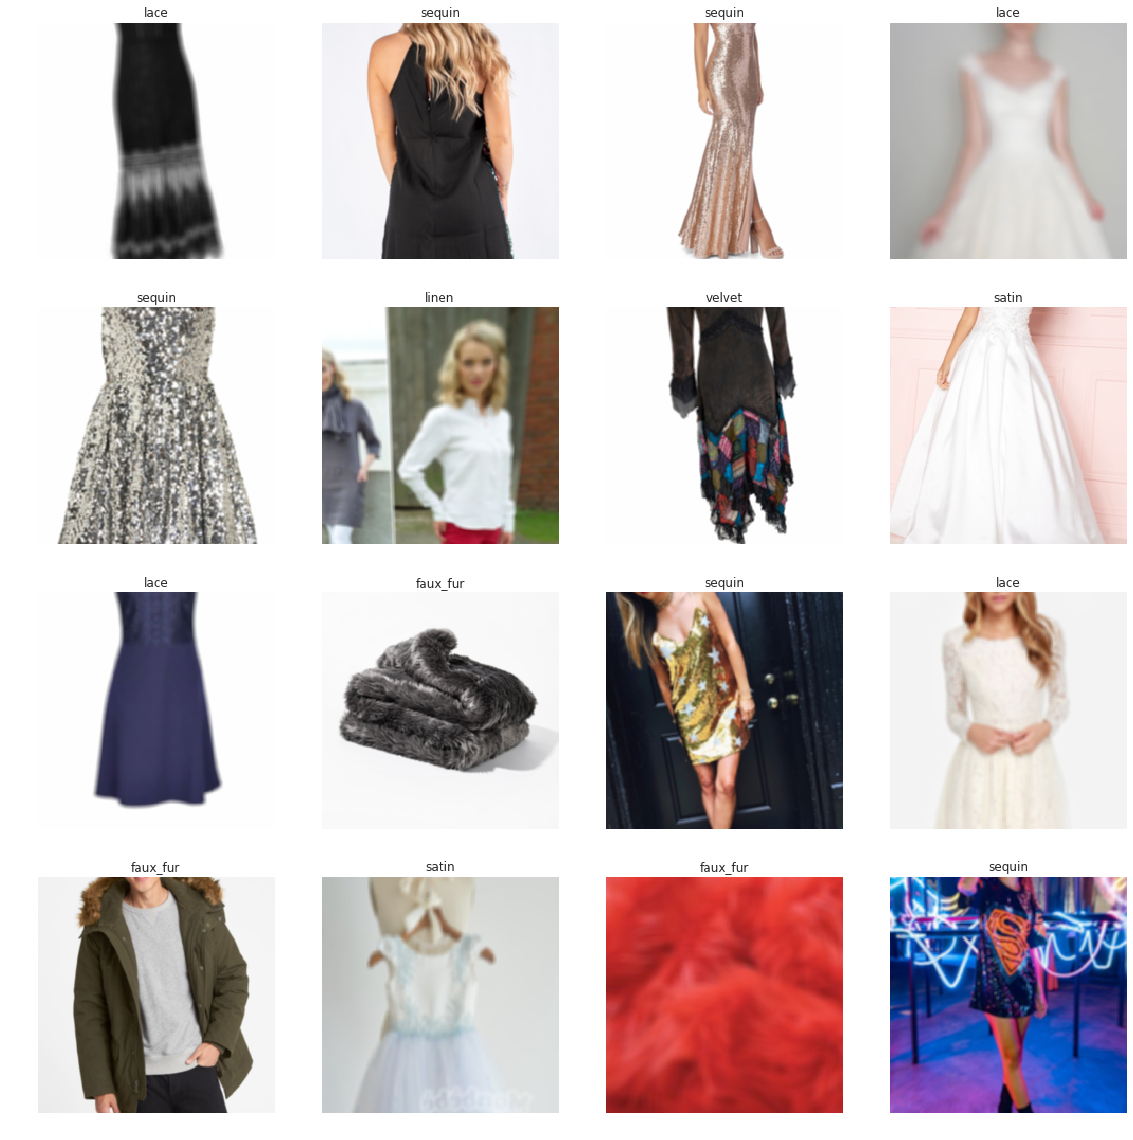

In [45]:
data_blur.show_batch(rows=4)

In [43]:
# load grayred and grayscale images into databunch
data_gray = ImageDataBunch.from_folder(path_images_gray,    # path for the dataset and model 
                                       valid_pct=0.2,       # train / val split
                                       ds_tfms=transforms,  # transforms
                                       size=224,            # image size
                                       bs=batch_size)       # batch size
data_gray.normalize(imagenet_stats)                         # normalization

ImageDataBunch;

Train: LabelList (3940 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
denim,denim,denim,denim,denim
Path: data/images_grayscale;

Valid: LabelList (984 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
velvet,satin,faux_leather,lace,lace
Path: data/images_grayscale;

Test: None

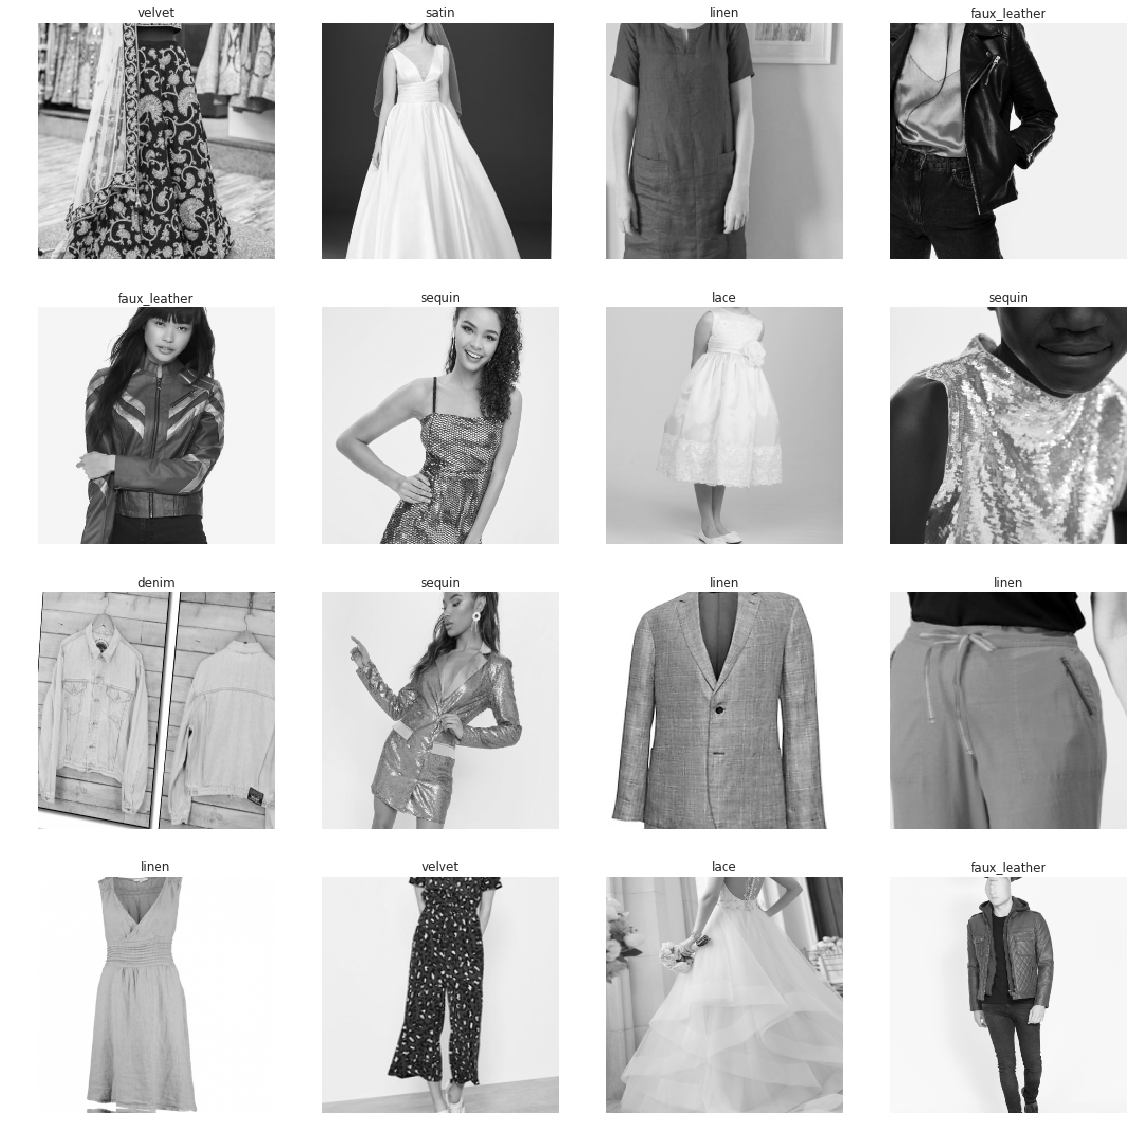

In [46]:
data_gray.show_batch(rows=4)

# Model training

### 1. Quick train of few additional last layers

In [47]:
model = cnn_learner(data, models.resnet34, metrics = error_rate)
model_blur = cnn_learner(data_blur, models.resnet34, metrics = error_rate)
model_gray = cnn_learner(data_gray, models.resnet34, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jupyter/.torch/models/resnet34-333f7ec4.pth
87306240it [00:04, 21396358.07it/s]


In [48]:
model.fit_one_cycle(4)

In [201]:
model_blur.fit_one_cycle(4)

In [192]:
model_gray.fit_one_cycle(4)

In [50]:
model.save('stage-1', return_path=True)
model_blur.save('stage-1-blur')
model_gray.save('stage-1-gray')

### 2. Train whole model with adjusted learning rates 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


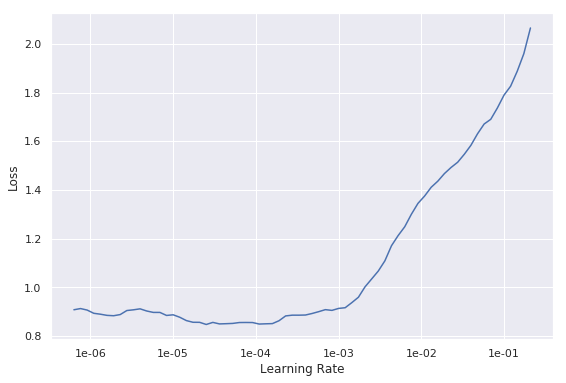

In [64]:
# unfreeze before lr_finder!!! 
# to find the best learning rates for retrain of the whole model
model.unfreeze() 
model.lr_find()
model.recorder.plot()

In [65]:
model.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
model.save('stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


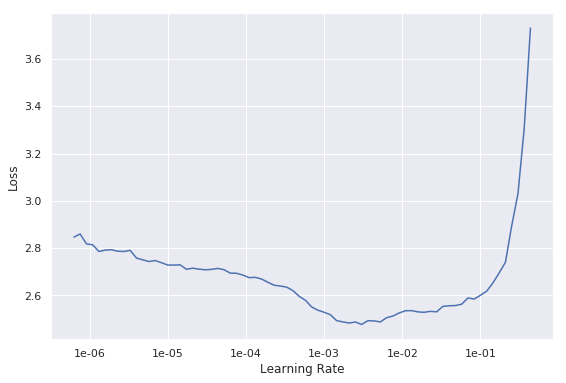

In [65]:
# unfreeze before lr_finder!!! 
# to find the best learning rates for retrain of the whole model
model_blur.unfreeze() 
model_blur.lr_find()
model_blur.recorder.plot()

In [ ]:
model_blur.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
model_blur.save('stage-2-blur')

# Interpretation

In [51]:
interp = ClassificationInterpretation.from_learner(model)
interp_blur = ClassificationInterpretation.from_learner(model_blur)
interp_gray = ClassificationInterpretation.from_learner(model_gray)

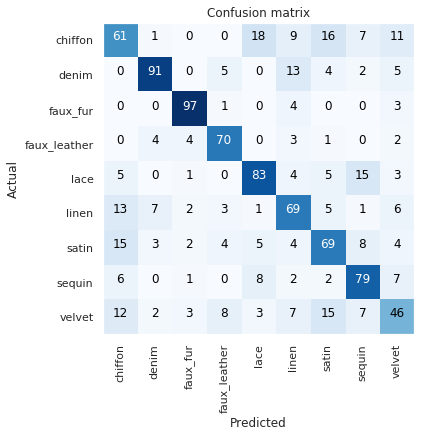

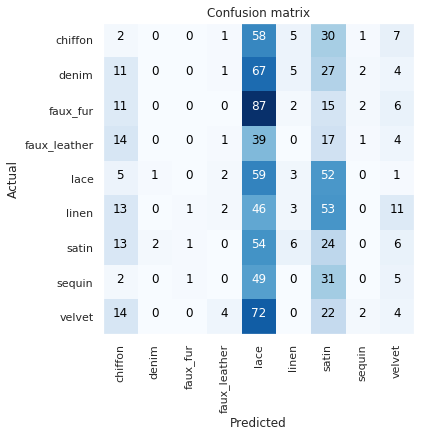

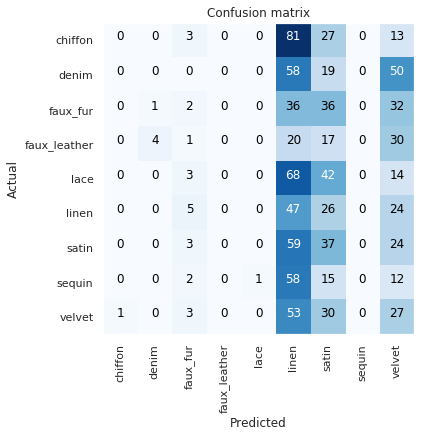

In [66]:
interp.plot_confusion_matrix(); interp_blur.plot_confusion_matrix(); interp_gray.plot_confusion_matrix();

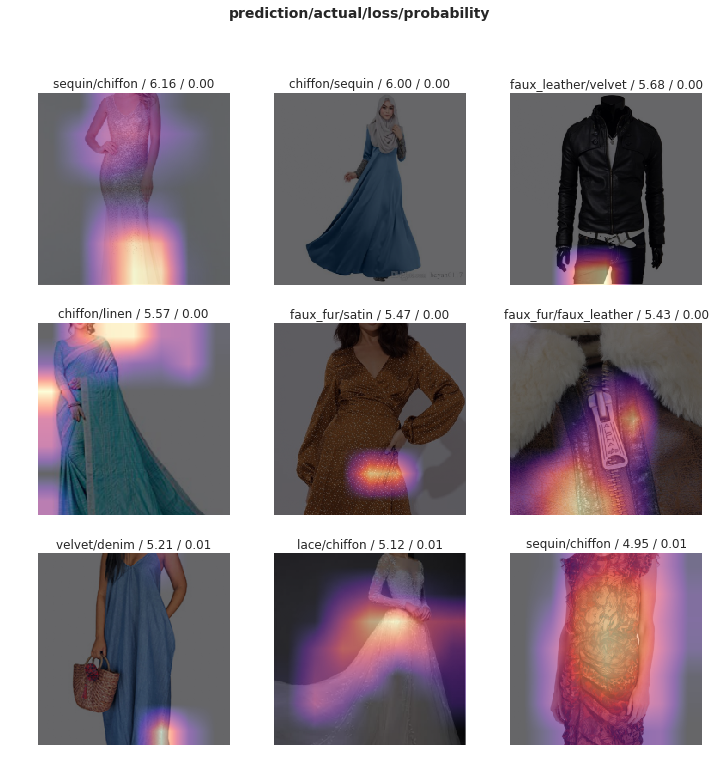

In [67]:
interp.plot_top_losses(9);

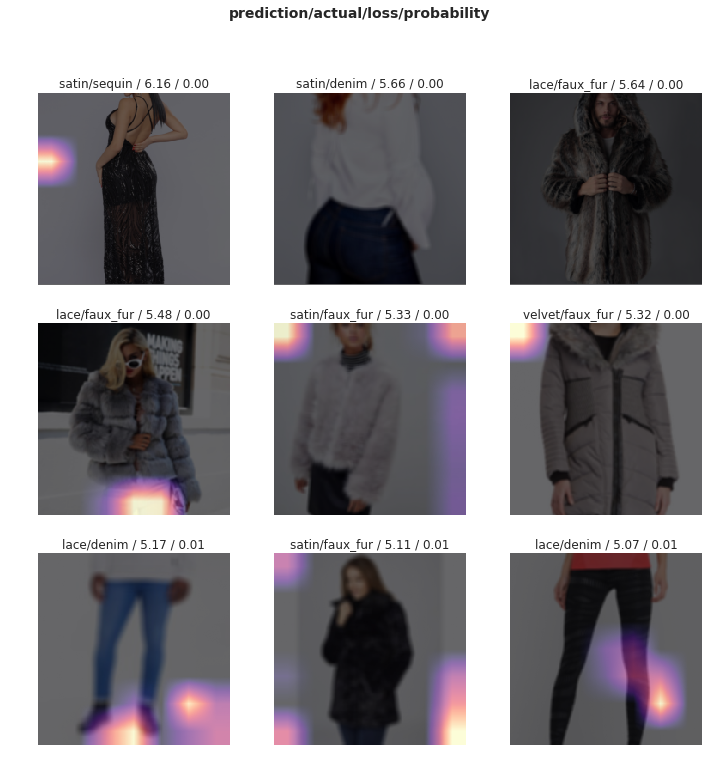

In [68]:
interp_blur.plot_top_losses(9);

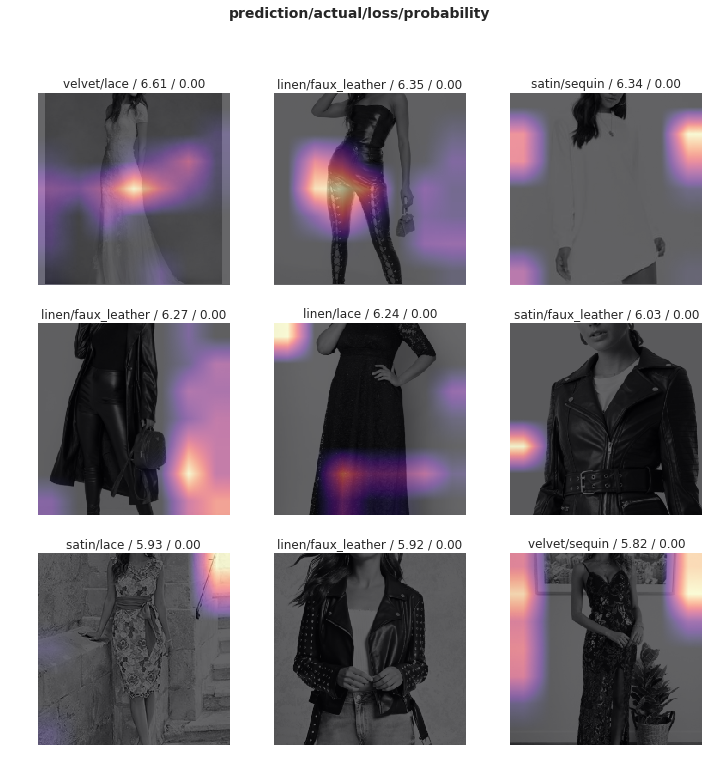

In [69]:
interp_gray.plot_top_losses(9);

# Data curating
- The main difficulty comes from ambigous image content: multiple types of clothes in the same image

### 1. Manually curate the images our classifier struggles most 
- wrong label
- multiple objects with only one label
- irrelevant 

In [70]:
ds, idxs = DatasetFormatter.from_toplosses(model, ds_type=DatasetType.Valid) #
ImageCleaner(ds, idxs, path_images)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

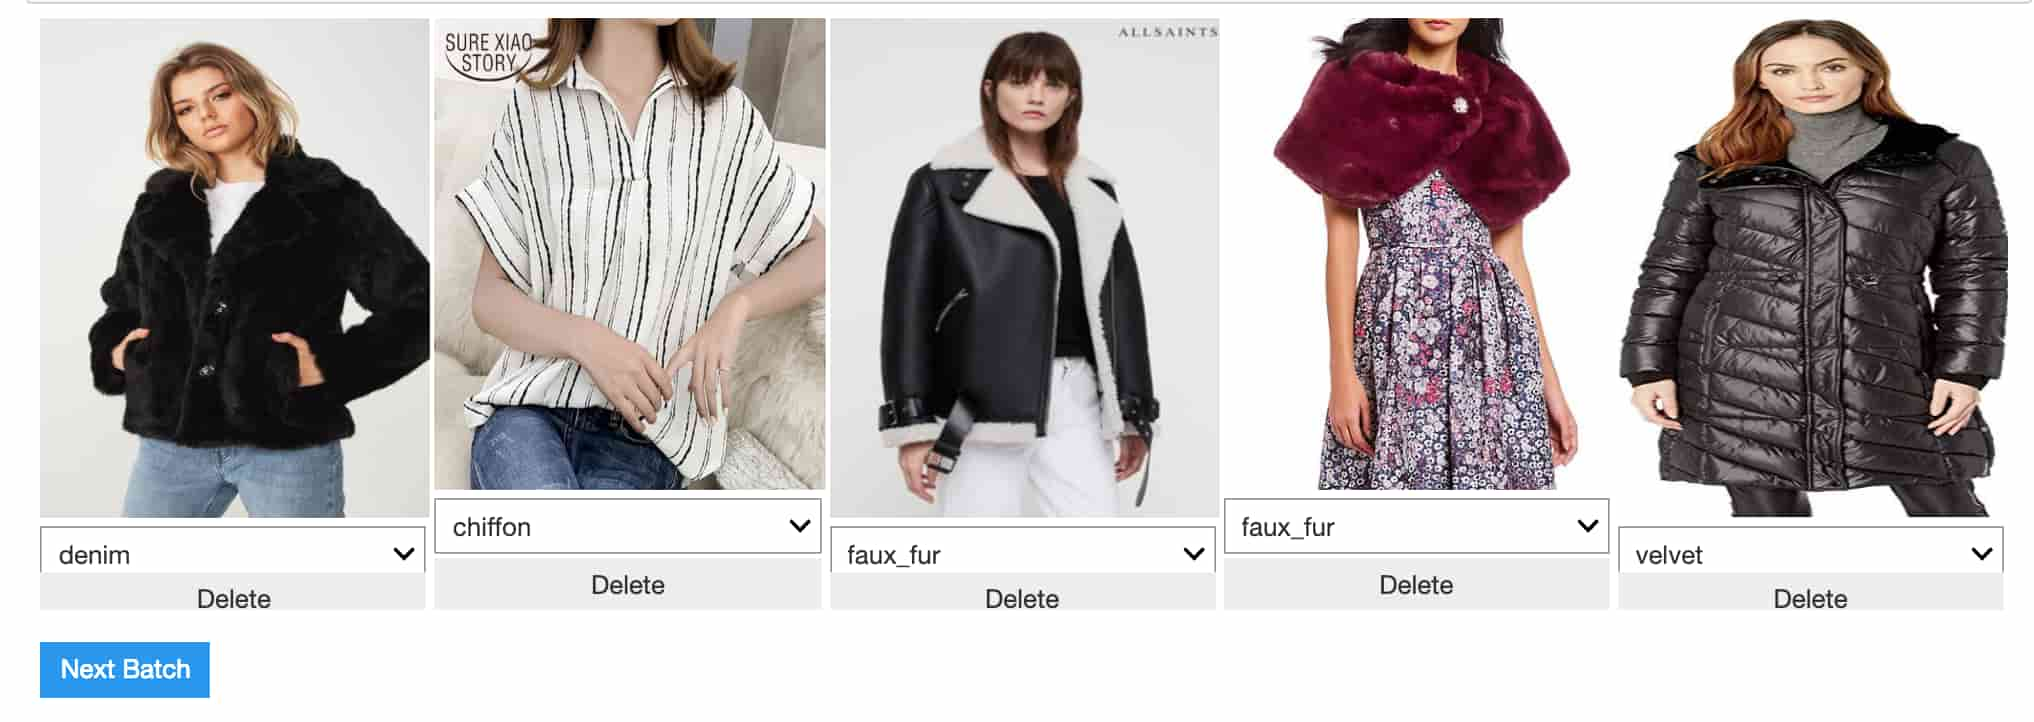

In [78]:
# screenshot of how the image cleaner UI looks like 
# fastai.widgets are not rendered in previews, and takes a long time to load for larger dataset
Image("image_cleaner.jpg")

### 2. Remove duplicates

In [11]:
ds, idxs = DatasetFormatter().from_similars(model, ds_type=DatasetType.Valid)
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### 3. Reload data with the curated csv file
=> retrain the model with the new dataset 

In [45]:
data2 = ImageDataBunch.from_csv(path_images, 
                                csv_labels = 'cleaned.csv',
                                ds_tfms = transforms,
                                bs = batch_size,
                                size = 224)

# Production

In [ ]:
# defaults.device = torch.device('cpu')  

In [49]:
model.export()

In [77]:
learn = load_learner(path/'models')

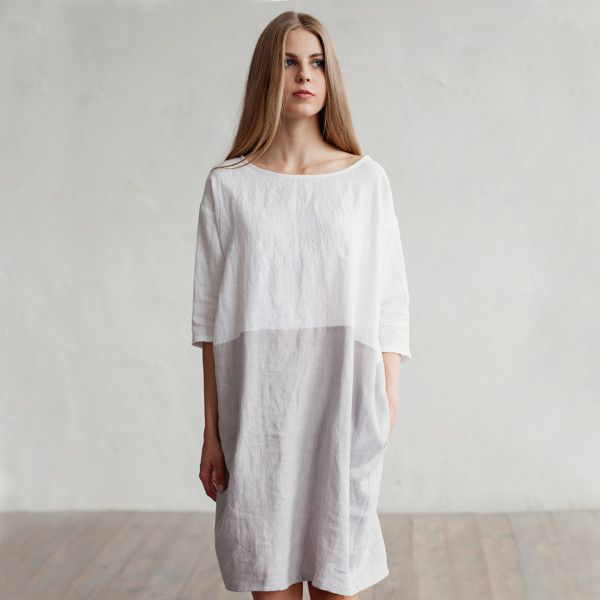

In [81]:
img = open_image(path_images/'linen/00000000.jpg'); img

In [83]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class, pred_idx, outputs

(Category linen,
 tensor(5),
 tensor([2.2161e-03, 4.3473e-04, 1.1868e-04, 1.2901e-05, 1.2847e-02, 9.8251e-01,
         4.5190e-04, 7.8775e-04, 6.2381e-04]))